<a href="https://colab.research.google.com/github/PasechnikDarya/RAAI-NLP-Project/blob/main/topic_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка данных

In [ ]:
import torch
import itertools
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/blogtext.csv')

In [ ]:
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [ ]:
data['text'][456]

"              Frustration  I'm so frustrated! At the lack of productivity. At the hunger pangs caused by waiting...waiting...waiting...  I'm meant BE at Soony and Michy's for dinner right now, yet am stuck waiting for my ride to come, who's in turn, stuck at a meeting which should have been settled eons ago. The complications of starting a new business. Sheesh...  Ah wells. Yuli is heading down now to hand me some forms for data entry. Yippee. Am finally  doing  something...           "

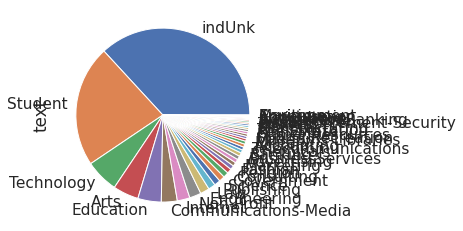

In [ ]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie()

In [ ]:
NUM_CLASSES = 5

data = data[data['topic'] != 'indUnk']
classes = data.groupby('topic', as_index=False).count()[['text', 'topic']].sort_values(['text'], ascending=False)['topic'].values[:NUM_CLASSES]

data = data[data['topic'].isin(classes)].reset_index(drop=True)

In [ ]:
frequencies = data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].values / data.shape[0]
frequencies

array([0.55324969, 0.15117909, 0.11664749, 0.10652455, 0.07239917])

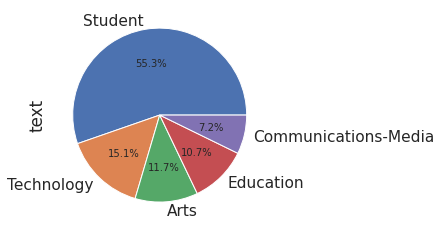

In [ ]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [ ]:
# for balanced data

# one_class_size = data[data['topic'] == classes[-1]].shape[0]

# prepr_data = pd.concat([data[data['topic'] == x][:one_class_size] for x in classes], axis=0)

# old_data = data
# data = prepr_data.reset_index(drop=True)

In [ ]:
CUT = data.shape[0] #100000

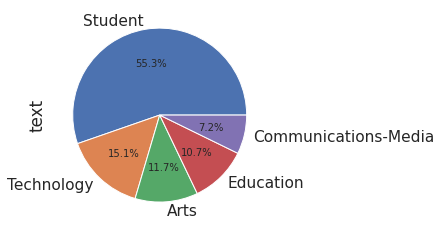

In [ ]:
data.loc[:CUT, :].groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [ ]:
label2idx = {label: i for i, label in enumerate(data['topic'].unique())}
idx2label = {i: label for i, label in enumerate(data['topic'].unique())}

In [ ]:
for i in idx2label.keys():
  if label2idx[idx2label[i]] != i:
    print('aaa')

In [ ]:
from sklearn.model_selection import train_test_split

train_indexes, test_indexes = train_test_split(data.index[:CUT], test_size=0.2, stratify=data['topic'][:CUT], shuffle=True)

In [ ]:
class Dataset:

    def __init__(self, data, labels, vocab=None):
        self.vocab = vocab
        self.data = data
        self.tokenised = None
        self.labels = [label2idx[label] for label in labels]

    def __getitem__(self, index):
        answer = {"input": self.tokenised[index]}
        if self.labels is not None:
            answer["label"] = self.labels[index]
        return answer

    def __len__(self):
        return len(self.data)
    
    def cut_to_fixed_size(self, max_size=512):
        self.tokenised = [text[:max_size] for text in tqdm(self.tokenised)]

    def drop_too_short(self, min_size=1):
      self.labels = [label for idx, label in tqdm(enumerate(self.labels)) if len(self.tokenised[idx]) > min_size]
      self.data = [text for idx, text in tqdm(enumerate(self.data)) if len(self.tokenised[idx]) > min_size]
      self.tokenised = [text for text in tqdm(self.tokenised) if len(text) > min_size]


In [ ]:
train_dataset = Dataset(list(data['text'].values[train_indexes]), list(data['topic'].values[train_indexes]))
test_dataset = Dataset(list(data['text'].values[test_indexes]), list(data['topic'].values[test_indexes]))

In [ ]:
import nltk

nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords as nltk_stopwords

nltk_stopwords = nltk_stopwords.words("english")

def is_word(word):
    word = word.lower()
    return all(x.isalpha() or x.isdigit() or x == "-" for x in word) and any(x.isalpha() or x.isdigit() for x in word)

def process_text(text, to_lower=True, only_alpha=True, remove_stopwords=False):
    words = wordpunct_tokenize(text) if isinstance(text, str) else text
    if to_lower:
        words = [word.lower() for word in words]
    if only_alpha:
        words = [word for word in words if is_word(word)]
    if remove_stopwords:
        words = [word for word in words if word not in nltk_stopwords]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(train_dataset.data)]
test_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(test_dataset.data)]

KeyboardInterrupt: ignored

# Загрузка эмбендингов

In [ ]:
class Vocabulary:

    def __init__(self, vocab=None):
        self.vocab = vocab

    def encode(self, data):
        if isinstance(data, list) and len(data) > 0 and not isinstance(data[0], str):
            return [self.encode(text) for text in data]
        # data --- это отдельный текст
        indexes = [self.vocab.get(token, self.vocab['unk']) for token in data]
        return indexes

In [ ]:
# import gensim.downloader as api
# glove_model = api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
##### bert #######

In [ ]:
from transformers import BertModel

In [ ]:
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_embeddings = list(bert.children())[0]
bert_word_embeddings = list(bert_embeddings.children())[0]
bert_embeddings = bert_word_embeddings.weight.data.numpy()

In [ ]:
bert_embeddings.shape

(30522, 768)

In [ ]:
tokenizer = ppb.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
max_len = 1000
for idx, text in tqdm(enumerate(train_dataset.data)):
    if len(text) > max_len:
        train_dataset.data[idx] = text[:max_len]

for idx, text in tqdm(enumerate(test_dataset.data)):
    if len(text) > max_len:
        test_dataset.data[idx] = text[:max_len]

In [ ]:
train_dataset.tokenised = [tokenizer.encode(x, add_special_tokens=True) for x in train_dataset.data]
test_dataset.tokenised = [tokenizer.encode(x, add_special_tokens=True) for x in test_dataset.data]

In [ ]:
len(train_dataset.tokenised[0])

191

In [ ]:
train_dataset.cut_to_fixed_size(256)
test_dataset.cut_to_fixed_size(256)

In [ ]:
train_dataset.drop_too_short()
test_dataset.drop_too_short()

In [ ]:
######### bert #########

In [ ]:
glove_word2idx = {word: idx for idx, word in enumerate(glove_model.index2word)}

glove_vocab = Vocabulary()
glove_vocab.vocab = glove_word2idx
# dataset.vocab = glove_vocab

In [ ]:
train_dataset.tokenised = glove_vocab.encode(train_dataset.tokenised)
test_dataset.tokenised = glove_vocab.encode(test_dataset.tokenised)

NameError: ignored

In [ ]:
train_dataset.cut_to_fixed_size(256)
test_dataset.cut_to_fixed_size(256)

In [ ]:
train_dataset.drop_too_short()
test_dataset.drop_too_short()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def pad_tensor(vec, length, dim, pad_symbol):
    pad_size = list(vec.shape)
    pad_size[dim] = length - vec.shape[dim]
    answer = torch.cat([vec, torch.ones(*pad_size, dtype=vec.dtype) * pad_symbol], axis=dim)
    return answer

def pad_tensors(tensors, dim=0, pad=0):
    # дополняет тензоры из tensors до общей максимальной длины символом pad
    if isinstance(tensors[0], (int, np.integer)):
        # массив целых чисел
        return torch.LongTensor(tensors)
    elif isinstance(tensors[0], (float, np.float)):
        # массив действительных чисел
        return torch.Tensor(tensors)
    if not isinstance(tensors[0], torch.Tensor):
        # приводим к массивам, чтобы можно было определить тип
        tensors = [np.array(tensor) for tensor in tensors]
        if np.issubdtype(tensors[0].dtype, np.integer):
            tensors = [torch.LongTensor(tensor) for tensor in tensors]
        else:
            tensors = [torch.Tensor(tensor) for tensor in tensors]
    L = max(tensor.shape[0] for tensor in tensors)
    tensors = [pad_tensor(tensor, L, dim=dim, pad_symbol=pad) for tensor in tensors]
    return torch.stack(tensors, dim=0)


class BatchDataLoader(DataLoader):

    def __init__(self, data, batch_size: int=32, pad=0, device="cpu", sort_field="input"):
        self.data = data
        self.batch_size = batch_size
        self.pad = pad
        self.device = device
        self.sort_field = sort_field

    def __iter__(self):
        self.order = np.argsort([len(elem[self.sort_field]) for elem in self.data])[::-1]
        self.idx = 0
        return self

    def __len__(self):
        return (len(self.data)-1) // self.batch_size + 1

    def __next__(self):
        if self.idx >= len(self.data):
            raise StopIteration()
        end = min(self.idx + self.batch_size, len(self.data))
        indexes = self.order[self.idx:end]
        # print(self.idx, end, indexes)
        answer = dict()
        for field in self.data[indexes[0]]:
            # записываем тензоры для всех полей
            answer[field] = pad_tensors([self.data[i][field] for i in indexes]).to(self.device)
        # записываем индексы всех объектов
        answer["indexes"] = indexes
        self.idx = end
        return answer

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x)
        state = states[0]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

def measure_quality(y_test, y_pred, average='weighted'):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'\t {average}')
    print("accuracy: {:.2f}".format(accuracy))
    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average=average)
    print("precision: {:.2f}".format(precision))
    print("recall: {:.2f}".format(recall))
    print("F1-score: {:.2f}".format(f_score))
    print()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "F1": f_score}

In [ ]:
from tqdm.notebook import tqdm, trange

def training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm=2, num_freeze_iter=1000):
    history = {
        'train_loss':[],
        'val_loss':[],
    }

    unfreeze_flg = False
    freeze_embeddings(model)
    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        
        train_loss = 0

        pbar = tqdm(loaders["train"], leave=False)
        for batch in pbar:

            if not unfreeze_flg and num_iter > num_freeze_iter:
                freeze_embeddings(model, True)
                unfreeze_flg = True
                
            optimizer.zero_grad()

            input_embeds = batch["input"].to(device)
            labels = batch["label"].to(device)

            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            train_loss += loss

            if num_iter % 1000 == 0:
                print('train loss: ', loss.item())
                print('train: ', (prediction.argmax(-1) == labels).float().sum().item())

            loss.backward()

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        
        history['train_loss'].append(train_loss / num_iter)

        valid_loss = 0
        val_labels = None
        val_predictions = None
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for batch in loaders["test"]:
                input_embeds = batch["input"].to(device)
                labels = batch["label"].to(device)
                prediction = model(input_embeds)
            
                valid_loss += criterion(prediction, labels)
                
                if val_labels is None:
                    val_labels = labels
                else:
                    val_labels = torch.hstack([val_labels, labels])
                
                if val_predictions is None:
                    val_predictions = prediction.argmax(-1)
                else:
                    val_predictions = torch.hstack([val_predictions, prediction.argmax(-1)])

                num_objs += len(labels)
                num_iter += 1

            print('valid: ', (prediction.argmax(-1) == labels).float().sum().item())

            val_labels = val_labels.cpu().numpy()
            val_predictions = val_predictions.cpu().numpy()

        history['val_loss'].append(valid_loss / num_iter)

        measure_quality(val_labels, val_predictions, 'weighted')
        measure_quality(val_labels, val_predictions, 'macro')
        measure_quality(val_labels, val_predictions, 'micro')

        print(f"\n\tValid Loss: {valid_loss / num_iter}\n\t")

    return history

In [ ]:
import torch
del model
torch.cuda.empty_cache()
import gc
gc.collect()

278774

In [ ]:
idx2label

{0: 'Student',
 1: 'Education',
 2: 'Communications-Media',
 3: 'Arts',
 4: 'Technology'}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)

# bert
model = LSTMModel(len(label2idx), embed_size=bert_embeddings.shape[1], vocab_size=bert_embeddings.shape[0]).to(device)
# bert

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(1 / frequencies).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
max_grad_norm = 1.0

In [ ]:
# bert
with torch.no_grad():
    model.embedding.weight = torch.nn.Parameter(torch.Tensor(bert_embeddings).to(device))

In [ ]:
# with torch.no_grad():
#     for word, idx in glove_vocab.vocab.items():
#         if word in glove_model:
#             model.embedding.weight[idx] = torch.from_numpy(glove_model.get_vector(word))

In [ ]:
loaders = {'train': BatchDataLoader(train_dataset, device="cuda:0", batch_size=30),
           'test': BatchDataLoader(test_dataset, device="cuda:0", batch_size=30)}

In [ ]:
history = training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm)

train loss:  1.602779746055603
train:  2.0
train loss:  1.6953336000442505
train:  4.0
train loss:  1.600977897644043
train:  6.0
train loss:  1.4153869152069092
train:  7.0
train loss:  1.543927550315857
train:  7.0
train loss:  1.1956268548965454
train:  9.0
train loss:  1.2389472723007202
train:  10.0
train loss:  1.691210150718689
train:  3.0
valid:  4.0
	 weighted
accuracy: 0.54
precision: 0.57
recall: 0.54
F1-score: 0.44

	 macro
accuracy: 0.54
precision: 0.60
recall: 0.25
F1-score: 0.21

	 micro
accuracy: 0.54
precision: 0.54
recall: 0.54
F1-score: 0.54


	Valid Loss: 1.6191927194595337
	


train loss:  1.690488576889038
train:  22.0
train loss:  1.6567206382751465
train:  9.0
train loss:  1.5253664255142212
train:  7.0
train loss:  1.358155369758606
train:  10.0
train loss:  1.3933565616607666
train:  10.0
train loss:  1.0993735790252686
train:  13.0
train loss:  1.1161993741989136
train:  12.0
train loss:  1.6306343078613281
train:  5.0
valid:  4.0
	 weighted
accuracy: 0.53
precision: 0.57
recall: 0.53
F1-score: 0.46

	 macro
accuracy: 0.53
precision: 0.53
recall: 0.28
F1-score: 0.24

	 micro
accuracy: 0.53
precision: 0.53
recall: 0.53
F1-score: 0.53


	Valid Loss: 1.6111953258514404
	


train loss:  1.8671643733978271
train:  22.0
train loss:  1.4820594787597656
train:  15.0
train loss:  1.373348355293274
train:  7.0
train loss:  1.3408056497573853
train:  10.0
train loss:  1.2904707193374634
train:  12.0
train loss:  1.0112168788909912
train:  15.0
train loss:  1.0606334209442139
train:  14.0
train loss:  1.5521628856658936
train:  7.0
valid:  4.0
	 weighted
accuracy: 0.44
precision: 0.60
recall: 0.44
F1-score: 0.44

	 macro
accuracy: 0.44
precision: 0.47
recall: 0.32
F1-score: 0.27

	 micro
accuracy: 0.44
precision: 0.44
recall: 0.44
F1-score: 0.44


	Valid Loss: 1.4539505243301392
	


train loss:  1.9465185403823853
train:  15.0
train loss:  1.3181849718093872
train:  14.0
train loss:  1.2623800039291382
train:  10.0
train loss:  1.2890539169311523
train:  13.0
train loss:  1.1790677309036255
train:  16.0
train loss:  0.9114855527877808
train:  16.0
train loss:  1.0482594966888428
train:  15.0
train loss:  1.5181561708450317
train:  8.0
valid:  4.0
	 weighted
accuracy: 0.41
precision: 0.57
recall: 0.41
F1-score: 0.42

	 macro
accuracy: 0.41
precision: 0.40
recall: 0.35
F1-score: 0.30

	 micro
accuracy: 0.41
precision: 0.41
recall: 0.41
F1-score: 0.41


	Valid Loss: 1.40707266330719
	


train loss:  1.839273452758789
train:  16.0
train loss:  1.301835536956787
train:  17.0
train loss:  1.2410621643066406
train:  13.0
train loss:  1.2531062364578247
train:  16.0
train loss:  1.1155341863632202
train:  15.0
train loss:  0.8952376246452332
train:  16.0
train loss:  0.9606049060821533
train:  15.0
train loss:  1.493266224861145
train:  9.0
valid:  4.0
	 weighted
accuracy: 0.43
precision: 0.56
recall: 0.43
F1-score: 0.45

	 macro
accuracy: 0.43
precision: 0.38
recall: 0.36
F1-score: 0.33

	 micro
accuracy: 0.43
precision: 0.43
recall: 0.43
F1-score: 0.43


	Valid Loss: 1.4423673152923584
	


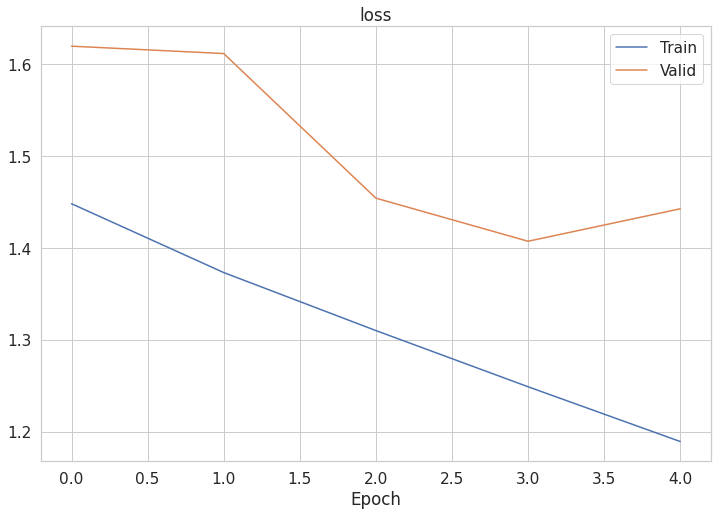

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x) #[:, -1, :]
        state = states[-1]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

    def train_on_batch(self, x, y):
        self.train()
        self.optimizer.zero_grad()
        loss = self._validate(x, y)
        loss["loss"].backward()
        self.optimizer.step()
        return loss

    def validate_on_batch(self, x, y):
        self.eval()
        with torch.no_grad():
            return self._validate(x, y)

    def _validate(self, x, y):
        if self.device is not None:
            y = y.to(self.device)
            x = x.to(self.device)
        prediction = self(x) #   self.forward(x) = self.__call__(x)
        loss = self.criterion(prediction, y)
        labels = prediction.argmax(-1)
        return {"loss": loss, "label": labels}

In [ ]:
def update_metrics(metrics, batch_output, batch_labels):
    n_batches = metrics["n_batches"]
    # Что здесь не так?
    metrics["loss"] = (metrics["loss"] * n_batches + batch_output["loss"].item()) / (n_batches + 1)
    metrics["n_batches"] += 1
    are_equal = (batch_output["label"] == batch_labels).cpu().numpy().astype("int")
    metrics["correct"] += are_equal.sum()
    metrics["total"] += are_equal.shape[0]
    metrics["accuracy"] = metrics["correct"] / max(metrics["total"], 1)

In [ ]:
def do_epoch(model, dataloader, mode="validate", epoch=1):
    metrics = {"correct": 0, "total": 0, "loss": 0.0, "n_batches": 1}

    func = model.train_on_batch if mode == "train" else model.validate_on_batch
    progress_bar = tqdm(dataloader, leave=True)
    progress_bar.set_description(f"{mode}, epoch={epoch}")

    for batch in progress_bar:
        batch_output = func(batch['input'], batch["label"])
        update_metrics(metrics, batch_output, batch["label"])
        progress_bar.set_postfix({"loss": round(metrics["loss"], 4), "acc": round(100 * metrics["accuracy"], 2)})
    return metrics

In [ ]:
train_dataloader = BatchDataLoader(train_dataset, device="cuda", batch_size=30)
test_dataloader = BatchDataLoader(test_dataset, device="cuda", batch_size=30)
NEPOCHS = 5

model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)

best_val_acc = 0.0
checkpoint = "checkpoint_best.pt"

for epoch in range(NEPOCHS):
    do_epoch(model, train_dataloader, mode="train", epoch=epoch+1)
    epoch_metrics = do_epoch(model, test_dataloader, mode="validate", epoch=epoch+1)

    if epoch_metrics["accuracy"] > best_val_acc:
        best_val_acc = epoch_metrics["accuracy"]
        print(f"Saving checkpoint after epoch {epoch+1}")
        torch.save(model.state_dict(), checkpoint)

model.load_state_dict(torch.load(checkpoint))
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")


Saving checkpoint after epoch 1


{'accuracy': 0.31128207723844714,
 'correct': 6150,
 'loss': 1.573903871666301,
 'n_batches': 660,
 'total': 19757}

In [ ]:
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")

Осталось:
1.   Разумные метрики вроде f1
2.   Сделать, чтобы училось, сейчас не учится
3.   С 0/1/2 полносвязными слоями, fastext и bert embendings



In [ ]:
torch.argmax(torch.Tensor([[1, 2], [5, 4]]), axis=1)

tensor([1, 0])

# BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 9.1MB/s 
     |████████████████████████████████| 3.3MB 33.7MB/s 
     |████████████████████████████████| 901kB 50.0MB/s 


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

NameError: ignored

In [ ]:
blade = 500

In [ ]:
text_data = data['text'][:blade]

In [ ]:
topics = data['topic'][:blade]

In [ ]:
labels = []
for topic in topics:
    labels.append(label2idx[topic])

In [ ]:
len(labels)

250

In [ ]:
max_len = 500
for text in tqdm(text_data.index):
    if len(text_data[text]) > max_len:
        text_data[text] = text_data[text][:max_len]

### Tokenization

In [ ]:
tokenized = text_data[:blade].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
tokenized

0      [101, 18558, 2038, 2042, 2179, 1006, 1009, 101...
1      [101, 2122, 2024, 1996, 2136, 2372, 1024, 3881...
2      [101, 1999, 21770, 26159, 2099, 3158, 22762, 2...
3      [101, 5604, 999, 999, 999, 5604, 999, 999, 999...
4      [101, 8299, 1024, 1013, 1013, 7479, 1012, 2039...
                             ...                        
245    [101, 2061, 1996, 3976, 2005, 1996, 2166, 1997...
246    [101, 2253, 2197, 2305, 2000, 1996, 7090, 6765...
247    [101, 2242, 8572, 2015, 2033, 2055, 1996, 2403...
248    [101, 4033, 1005, 1056, 6866, 2505, 1999, 1037...
249    [101, 2619, 3531, 4863, 2000, 2033, 2129, 2619...
Name: text, Length: 250, dtype: object

### Padding

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

### Masking

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(250, 178)

### Model

In [ ]:
input_ids = torch.tensor(np.array(padded))

with torch.no_grad():
    last_hidden_states = model(input_ids)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = labels[:blade]

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_clf.score(test_features, test_labels)

0.6984126984126984

In [ ]:
# равномерно 100 samples - 0.6, 0.76, 0,68
# равномерно250 samples - 0.6984